In [1]:
import os
import sys
import glob
import thread_utils
import math
import multiprocessing
import getopt
import time
import numpy as np
import tensorflow as tf

In [34]:
# For rgb+albedo+normals, set it to 9
INPUT_DIMENSION = 3

# Number of training epochs. Each epoch is a complete pass over the training images
num_epochs = 20

# Save training data to a checkpoint file after each x epochs
save_after_num_epochs = 10

# Minibatch size. After each sequence of minibatch images the loss function is
# evaluated and weights are updated. Changing the value has an effect on the
# loss calculation as well on the performance.
minibatch_size = 4

# Crop image size. During training a random image region is used for comparison
# of input and target.
cropSize = [256, 256]

# Path where graph and tensorboard statistic files are saved. The graph file is
# needed when generating the weights for inference.
SAVE_DIRECTORY = "training_result"

# Configuration of training image files
# TRAIN_DIRECTORY contains three subdirectories:
# rgb
#   This directory contains rgb images for training. The filenames must end
#   with _XXXXXX.npy where XXXXXX is the number of samples used in rendering.
#   For each scene there can be multiple such progressive rendered images. The target
#   (ground thruth / reference) image filename must end with _target.npy for each
#   set of iteration images.
# albedo
#   Contains albedo/bsdf images
# normals
#   Contains normal/xyz images

TRAIN_DIRECTORY  = 'training_data'

###############################################################################

restore = "C:/Users/Jo/Documents/project/denoiser_training/training_result/model_20.ckpt"

In [3]:
def variable_summaries(var, name):
    """Attach a lot of summaries to a Tensor (for TensorBoard visualization)."""
    with tf.name_scope(name):
        #mean = tf.reduce_mean(var)
        #tf.summary.scalar('mean', mean)
        #with tf.name_scope('stddev'):
        #    stddev = tf.sqrt(tf.reduce_mean(tf.square(var - mean)))
        #tf.summary.scalar('stddev', stddev)
        tf.summary.scalar('max', tf.reduce_max(var))
        tf.summary.scalar('min', tf.reduce_min(var))
        tf.summary.histogram('histogram', var)

def conv2d(x, out_channel, name='conv', relu = True):

    with tf.name_scope(name) as scope:
        in_shape = x.get_shape().as_list()
        in_channel = in_shape[-1]

        # Weights according to He initializer
        filter_shape = [3, 3, in_channel, out_channel]

        fan_in = 3.0*3.0*in_channel
        if relu:
            W = tf.Variable(tf.truncated_normal(filter_shape, stddev=math.sqrt(2.0 / fan_in)), name='W')
            variable_summaries(W, 'weight')
        else:
            W = tf.Variable(tf.truncated_normal(filter_shape, stddev=math.sqrt(1.0 / fan_in)), name='W')
            variable_summaries(W, 'weight')
        b = tf.Variable(tf.zeros([out_channel]), name='b')

        res = tf.nn.conv2d(x, W, strides=[1, 1, 1, 1], padding='SAME', name=name)
        res = tf.nn.bias_add(res, b ,name='bias')
        if relu:
            res = tf.nn.relu(res, name = 'relu')

    return res

def maxpool2d(x, k=2, name='pool'):
    # MaxPool2D wrapper
    with tf.name_scope(name) as scope:
        res = tf.nn.max_pool(x, ksize=[1, k, k, 1], strides=[1, k, k, 1],
                              padding='SAME', name=name)
    return res

def unpool(value, name='unpool'):
    with tf.name_scope(name) as scope:
        in_shape = value.get_shape().as_list()
        in_channel = in_shape[-1]

        filter_shape = [2, 2, in_channel, in_channel]
        out_shape = [in_shape[0], in_shape[1]*2, in_shape[2]*2, in_shape[3]]

        # Setup weights for nearest neighbour upscaling
        weights = np.zeros(filter_shape)
        for y in range(0, filter_shape[0]):
            for x in range(0, filter_shape[1]):
                for ic in range(0, filter_shape[2]):
                    for oc in range(0, filter_shape[3]):
                        if ic == oc:
                            weights[y][x][ic][oc] = 1.0
                        else:
                            weights[y][x][ic][oc] = 0.0
        W = tf.constant(weights, dtype=tf.float32, shape=filter_shape)
        res = tf.nn.conv2d_transpose(value, W, output_shape=out_shape, strides=[1, 2, 2, 1], padding='SAME')
        return tf.nn.relu(res)

def unpool_concat(a, b, name='upconcat'):
    with tf.name_scope(name) as scope:
        up = unpool(a)
        res = tf.concat([up, b], 3)
    return res

def concat(a, b, name):
    with tf.name_scope(name) as scope:
        return tf.concat([a, b], 3)

def autoencoder(x):

    prevLayer = conv1  = conv2d(x, 32, 'conv1')
    prevLayer = conv1b = conv2d(prevLayer, 32, 'conv1b')
    prevLayer = pool1  = maxpool2d(prevLayer, 2, 'pool1') # 256 -> 128

    prevLayer = conv2 = conv2d(prevLayer, 48, 'conv2')
    prevLayer = pool2 = maxpool2d(prevLayer, 2, 'pool2') # 128 -> 64

    prevLayer = conv3 = conv2d(prevLayer, 56, 'conv3')
    prevLayer = pool3 = maxpool2d(prevLayer, 2, 'pool3') # 64 -> 32

    prevLayer = conv4 = conv2d(prevLayer, 80, 'conv4')
    prevLayer = pool4 = maxpool2d(prevLayer, 2, 'pool4') # 32 -> 16

    prevLayer = conv5 = conv2d(prevLayer,  104, 'conv5')
    prevLayer = pool5 = maxpool2d(prevLayer, 2, 'pool5') # 16 -> 8

    prevLayer = us6 = unpool_concat(prevLayer, pool4, 'unpool4')
    prevLayer = conv6 = conv2d(prevLayer,  152, 'conv6')
    prevLayer = conv6b = conv2d(prevLayer, 152, 'conv6b')

    prevLayer = us7 = unpool_concat(prevLayer, pool3, 'unpool3')
    prevLayer = conv7 = conv2d(prevLayer, 112, 'conv7')
    prevLayer = conv7b = conv2d(prevLayer, 112, 'conv7b')

    prevLayer = us8 = unpool_concat(prevLayer, pool2, 'unpool2')
    prevLayer = conv8 = conv2d(prevLayer, 88, 'conv8')
    prevLayer = conv8b = conv2d(prevLayer, 88, 'conv8b')

    prevLayer = us9 = unpool_concat(prevLayer, pool1, 'unpool1')
    prevLayer = conv9 = conv2d(prevLayer,  64, 'conv9')
    prevLayer = conv9b = conv2d(prevLayer, 64, 'conv9b')

    prevLayer = us10 = unpool_concat(prevLayer, x, 'unpool0')    
    prevLayer = conv10 = conv2d(prevLayer, 64, 'conv10')
    prevLayer = conv10b = conv2d(prevLayer, 32, 'conv10b')

    out = conv2d(prevLayer, 3, 'conv11', relu = False)

    #print("Output var: %s" % out.name)

    return out

In [4]:

AEInputImg  = tf.placeholder(tf.float32, shape=[minibatch_size, cropSize[0], cropSize[1], INPUT_DIMENSION], name="Input")
AETargetImg = tf.placeholder(tf.float32, shape=[minibatch_size, cropSize[0], cropSize[1], 3], name="Target")
AELearningRate = tf.placeholder(tf.float32, shape=[])

AEOutput = autoencoder(AEInputImg)

# L2 loss function
with tf.name_scope("loss") as scope:
    AECost = tf.sqrt(tf.reduce_mean(tf.square(tf.subtract(AETargetImg, AEOutput))))
tf.summary.scalar('loss', AECost)

AEOptimizer = tf.train.AdamOptimizer(learning_rate=AELearningRate).minimize(AECost)

init = tf.global_variables_initializer()

# Configuration of learning rate decay
learning_rate_max     = 0.001
learning_rate_initial = learning_rate_max / 10
learning_rate_rampup_length = 10
learning_rate_rampup  = (learning_rate_max/learning_rate_initial) ** (1./learning_rate_rampup_length)
learning_rate         = learning_rate_initial
learning_rate_den     = 1000 // minibatch_size

# Add ops to save and restore all the variables.
saver = tf.train.Saver(tf.global_variables(), max_to_keep=1000)
merged = tf.summary.merge_all()

Instructions for updating:
Colocations handled automatically by placer.


In [6]:
def getshape(file):
    rd = open(file, 'rb')
    data = rd.read(80)
    x = data.split()
    return [int(x[5][1:-1]), int(x[6][0:-1]), int(x[7][0:-2])]

# Utility class to handle reading input images
class TrainingInput:

    def __init__(self, TDIR):

        self.train_dir = TDIR
        # get all training images (i.e. exclude all _target.npy images)
        self.trainFiles = [fn for fn in glob.glob(os.path.join(self.train_dir+"/rgb", '*.npy'))
                   if not os.path.basename(fn).endswith('_target.npy')]
        print ('Number of training files:', len(self.trainFiles)) 
        if (len(self.trainFiles) == 0):
            print ('No training files')
            sys.exit()

    def iterate_minibatches(self, batchsize, epoch, dim, shuffle=False, cropsize=None):
        # limit number of files to multiples of batchsize, which is a power of 2
        num = len(self.trainFiles) & ~(batchsize-1)
        indices = np.arange(num) 
        if shuffle: 
            np.random.shuffle(indices) 

        for start_idx in range(0, num, batchsize):
            start_idx = start_idx + epoch
            excerpt = indices[start_idx: min(start_idx + batchsize,num)]                # indices for this minibatch

            inputs  = []
            targets = []

            for i in excerpt:
                input_file  = self.trainFiles[i]
                target_file = os.path.join(self.train_dir+"/rgb", os.path.basename(input_file)[:-10] + "target.npy")
                albedo_file = os.path.join(self.train_dir+"/albedo", os.path.basename(input_file)[:-4] + ".npy")
                normal_file = os.path.join(self.train_dir+"/normal", os.path.basename(input_file)[:-4] + ".npy")

                # source image size
                sh = getshape(input_file)
                w = sh[1]
                h = sh[0]

                # Select a random crop
                cw, ch = w, h
                ow, oh = 0,0
                if cropsize != None:
                    cw,ch = cropsize[1],cropsize[0]
                    sw,sh = max(0,w-cw), max(0,h-ch)
                    ow,oh = np.random.randint(0,sw+1), np.random.randint(0,sh+1)

                imgs = [np.memmap(input_file,  dtype='float32', mode='r', offset=80+oh*w*3, shape=(ch, w, 3))[:,ow:ow+cw,:]]
                if (dim >= 6):
                    imgs.append(np.memmap(albedo_file,  dtype='float32', mode='r', offset=80+oh*w*3, shape=(ch, w, 3))[:,ow:ow+cw,:])
                if (dim == 9):
                    imgs.append(np.memmap(normal_file,  dtype='float32', mode='r', offset=80+oh*w*3, shape=(ch, w, 3))[:,ow:ow+cw,:])
                imgs.append(np.memmap(target_file,  dtype='float32', mode='r', offset=80+oh*w*3, shape=(ch, w, 3))[:,ow:ow+cw,:])

                imgs = [np.swapaxes(np.swapaxes(img, 1, 2), 0, 1)  for img in imgs]

                # Slice and dice.
                if (dim == 3):
                    inputs.append(imgs[0])
                    targets.append(imgs[1]) # target
                if (dim == 6):
                    inputs.append(np.concatenate((imgs[0], imgs[1]))) # input + features
                    targets.append(imgs[2]) # target
                if (dim == 9):
                    inputs.append(np.concatenate((imgs[0], imgs[1], imgs[2]))) # input + features
                    targets.append(imgs[3]) # target

            yield inputs, targets

    def getNumElements(self):
        return len(self.trainFiles)

def printProgress(iteration, total, prefix = '', suffix = '', decimals = 1, barLength = 100):
    formatStr = "{0:." + str(decimals) + "f}"
    percent = formatStr.format(100 * (iteration / float(total)))
    filledLength = int(round(barLength * iteration / float(total)))
    bar = unichr(0x78) * filledLength + '-' * (barLength - filledLength)
    sys.stdout.write('\r%s |%s| %s%s %s' % (prefix, bar, percent, '%', suffix)),
    if iteration == total:
        sys.stdout.write('\n')
    sys.stdout.flush()

def shuffleImg(x):
        x = np.swapaxes(x, 1, 2);
        x = np.swapaxes(x, 2, 3);
        return x;

In [13]:
from glob import glob
import cv2
import random
import numpy as np
import matplotlib.pyplot as plt
file_name=glob('C:/Users/Jo/Documents/project/denoiser_training/1spp/*.[pP][pP][mM]' )
noise_image=[]
FileList=[]
# get all file name
for x in file_name:
    FileList.append(x)
target_width=256
target_height=256

def crop_image(img):
    crop_img=[]

    w = target_width
    h = target_height

    for j in range(2):
        for i in range(2):
        
            x=i*256
            y=j*256


#             if j==5:
#                 y=720-256
                
            crop_img.append(img[y:y+h, x:x+w]/255)
            
    return crop_img

path_t='C:/Users/Jo/Documents/project/denoiser_training/400spp/optixPathTracer'

def remap(x):
    return x - 0.5

for i in range(1):
    filename_x=FileList[i]
    
    #     get file number
    str_f=filename_x.split('optixPathTracernoise_')[1]
    num=int(str_f.split('.ppm')[0])
#     print(str_f)

    img_x=cv2.imread(filename_x)
    img_x=img_x[:,:,::-1]
#     print(img_x[0])
    imgArr_x=crop_image(img_x)
    imgArr_x=np.array(imgArr_x, dtype=np.float32)
#     print(imgArr_x.shape)
    
    #     get ground truth
    filename_y=(path_t+repr(num)+".ppm")
#     print(filename_y)
    img_y=cv2.imread(filename_y)
    img_y=img_y[:,:,::-1]
    
    imgArr_y=crop_image(img_y)
    imgArr_y=np.array(imgArr_y, dtype=np.float32)
    
    
    
#     print(imgArr_x.shape)
#     for j in range(imgArr_y.shape[0]):
#         img=np.zeros((256,256,3), np.float32)
#         img[:,:,:]=imgArr_x[j]

In [35]:
with tf.Session() as sess:

    if (restore != None):
        saver.restore(sess, restore)
        print ("Restored model", restore)
        [summary, cost, dummy,out] = sess.run([merged, AECost, AEOptimizer,AEOutput], feed_dict={AEInputImg: imgArr_x, AETargetImg: imgArr_y, AELearningRate: learning_rate})


INFO:tensorflow:Restoring parameters from C:/Users/Jo/Documents/project/denoiser_training/training_result/model_20.ckpt
Restored model C:/Users/Jo/Documents/project/denoiser_training/training_result/model_20.ckpt


In [36]:
# print(summary)
print(cost)
# print(dummy)

0.07502393


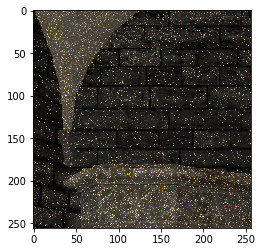

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


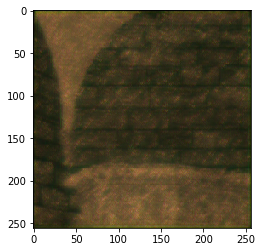

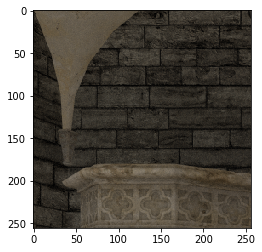

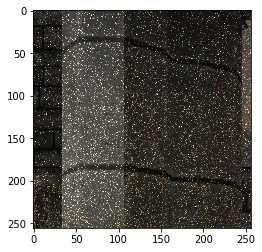

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


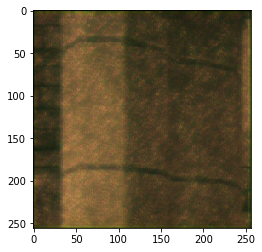

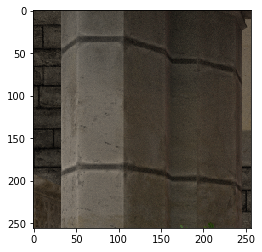

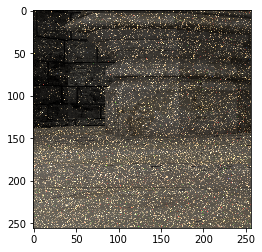

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


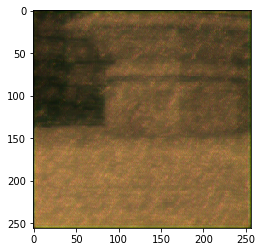

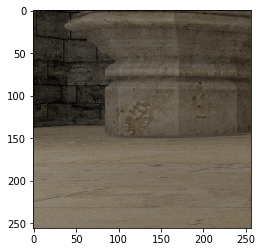

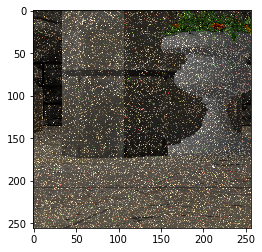

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


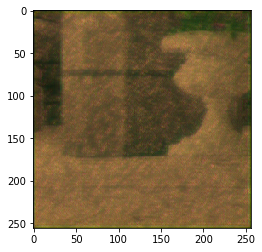

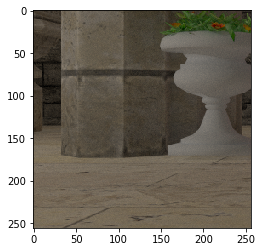

In [40]:
for i in range(4):
    plt.imshow(imgArr_x[i])
    plt.show()
    plt.imshow(out[i])
    plt.show()
    plt.imshow(imgArr_y[i])
    plt.show()